In [1]:
%matplotlib inline

In [2]:
import os
import netCDF4
import numpy as np
from geophys_utils import NetCDFLineUtils
import matplotlib.pyplot as plt
from geophys_utils import array2file
from osgeo import gdal
from geophys_utils import CSWUtils
import os
import re
from netCDF4 import Dataset
from pprint import pprint
import requests
import math
from scipy.interpolate import griddata
from geophys_utils import transform_coords, get_utm_wkt, get_spatial_ref_from_wkt

In [3]:
# Setup proxy as required
GA_STAFF_WIFI = False

if GA_STAFF_WIFI:
    os.environ['http_proxy'] = 'http://proxy.inno.lan:3128'
    os.environ['https_proxy'] = 'http://proxy.inno.lan:3128'

In [4]:
# N.B: GA internal CSW addresses will need port forwarding to work from the NCI
# Also, dev.public.ecat.ga.gov.au requires a hack to csw_utils and owslib to overcome certificate problem

csw_url = 'https://dev.public.ecat.ga.gov.au/geonetwork/srv/eng/csw' # GA's internally-facing development eCat
#csw_url = 'https://ecat.ga.gov.au/geonetwork/srv/eng/csw' # GA's externally-facing eCat
#csw_url = 'https://internal.ecat.ga.gov.au/geonetwork/srv/eng/csw' # GA's internally-facing eCat
#csw_url = 'http://geonetworkrr2.nci.org.au/geonetwork/srv/eng/csw' # NCI GeoNetwork

In [5]:
# Set up search criteria
bounds = (120.0, -29.0, 121, -28) # Spatial subset of dataset in WGS84 coordinates
keywords = 'geophysics,airborne digital data,geophysical survey,magnetics,line,AWAGS' # Comma-separated list of keywords

In [6]:
# Set spatial information about bounds
wgs84_wkt = get_spatial_ref_from_wkt('EPSG:4326').ExportToWkt()
centre_coords = [(bounds[dim_index] + bounds[dim_index+2]) / 2.0 for dim_index in range(2)]

utm_wkt = get_utm_wkt(centre_coords, wgs84_wkt)
reprojected_bounding_box = np.array(transform_coords(((bounds[0], bounds[1]), (bounds[2], bounds[1]), (bounds[2], bounds[3]), (bounds[0], bounds[3])), wgs84_wkt, utm_wkt))
utm_bounds = [min(reprojected_bounding_box[:,0]), 
              min(reprojected_bounding_box[:,1]), 
              max(reprojected_bounding_box[:,0]), 
              max(reprojected_bounding_box[:,1])]

print wgs84_wkt
print centre_coords
print utm_wkt
print utm_bounds

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]
[120.5, -28.5]
PROJCS["UTM Zone 51, Southern Hemisphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9108"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1]]
[204956.51141957112, 6788302.6266548373, 305179.01592085767, 6901185.7464002995]


In [7]:
def get_netcdf_datasets(keywords, bounds, csw_url):
    '''
    Find all datasets of interest and return a list of NetCDF file paths or OPeNDAP web service endpoints
    '''    
    #create a csw_utils object and populate the parameters with search parameters
    try:
        # N.B: "verify" parameter requires hack to geophys_utils.csw_utils, owslib.csw & owslib.utils 
        cswu = CSWUtils(csw_url, verify=False) 
    except:
        cswu = CSWUtils(csw_url) 
        
    print 'Querying CSW'
    record_list = [record for record in cswu.query_csw(keyword_list=keywords,
                                      #anytext_list=allwords,
                                      #titleword_list=titlewords,
                                      bounding_box=bounds,
                                      #start_datetime=start_date,
                                      #stop_datetime=end_date,
                                      #max_total_records=2000
                                      )
              ]
    print '%d matching dataset records found from CSW' % len(record_list)
    
    netcdf_list = [distribution['url']
            for distribution in cswu.get_netcdf_urls(record_list)
            ]

    print '%d NetCDF distributions found' % len(netcdf_list)
    
    return netcdf_list


In [8]:
def get_points(datasets, bounds, variable_name, coordinate_wkt):
    '''
    Return coordinates and values of the specified variable for all points from the supplied dataset list 
    which fall within bounds
    '''    
    coordinates = []
    values = []
    line_dataset_count = 0
    for dataset in datasets:
        print 'Reading and reprojecting line dataset %s' % dataset
        try:
            nc_dataset = Dataset(dataset)
            mag_awags_variable = nc_dataset.variables[variable_name]
            netcdf_line_utils = NetCDFLineUtils(nc_dataset) 
            reprojected_bounds = netcdf_line_utils.get_reprojected_bounds(bounds, coordinate_wkt, netcdf_line_utils.wkt)
            #print netcdf_line_utils.__dict__
            spatial_selection_indices = np.where(netcdf_line_utils.get_spatial_mask(reprojected_bounds))[0]
            print '%d/%d points found' % (len(spatial_selection_indices), len(mag_awags_variable))
            coordinates += list(transform_coords(netcdf_line_utils.xycoords[spatial_selection_indices],
                                                 netcdf_line_utils.wkt, 
                                                 coordinate_wkt))
            values += list(mag_awags_variable[spatial_selection_indices])
            line_dataset_count += 1
    
        except Exception as e:
            print 'Unable to read line dataset %s: %s' % (distribution['url'], e.message)
    
    # Convert lists to arrays
    print "Converting lists to arrays"
    values=np.array(values)
    coordinates=np.array(coordinates)
    assert values.shape[0] == coordinates.shape[0], 'Mismatched coordinate and value counts'
    print "A total of %d points were read from %d line datasets" % (values.shape[0], line_dataset_count)
    
    print 'Discarding invalid values'
    valid_mask=~np.isnan(values)
    values = values[valid_mask]
    coordinates = coordinates[valid_mask]
    print "A total of %d valid points were read" % values.shape[0]
    
    return coordinates, values

In [9]:
def grid_points(coordinates,
                coordinate_wkt,
                values,
                grid_wkt, 
                grid_bounds,
                grid_resolution, 
                resampling_method='linear', 
                point_step=1):
    '''
    Return interpolated grid from supplied coordinates and points
    '''
    
    # Determine spatial grid bounds rounded out to nearest GRID_RESOLUTION multiple
    pixel_centre_bounds = (round(math.floor(grid_bounds[0] / grid_resolution) * grid_resolution, 6),
                   round(math.floor(grid_bounds[1] / grid_resolution) * grid_resolution, 6),
                   round(math.floor(grid_bounds[2] / grid_resolution - 1.0) * grid_resolution + grid_resolution, 6),
                   round(math.floor(grid_bounds[3] / grid_resolution - 1.0) * grid_resolution + grid_resolution, 6)
                   )
    
    grid_size = [pixel_centre_bounds[dim_index+2] - pixel_centre_bounds[dim_index] for dim_index in range(2)]

    print "Reprojecting coordinates"
    grid_coordinates = np.array(transform_coords(coordinates, coordinate_wkt, grid_wkt))

    print "Computing spatial mask"
    spatial_subset_mask = np.logical_and(np.logical_and((grid_bounds[0] <= grid_coordinates[:,0]), 
                                                        (grid_coordinates[:,0] <= grid_bounds[2])), 
                                         np.logical_and((grid_bounds[1] <= grid_coordinates[:,1]), 
                                                        (grid_coordinates[:,1] <= grid_bounds[3]))
                                        )    
    # Create grids of Y and X values. Note YX ordering and inverted Y
    # Note GRID_RESOLUTION/2.0 fudge to avoid truncation due to rounding error
    print "Generating grid coordinates"
    grid_y, grid_x = np.mgrid[pixel_centre_bounds[3]:pixel_centre_bounds[1]-grid_resolution/2.0:-grid_resolution, 
                             pixel_centre_bounds[0]:pixel_centre_bounds[2]+grid_resolution/2.0:grid_resolution]

    # Skip points to reduce memory requirements
    point_subset_mask = np.zeros(shape=values.shape, dtype=bool)
    point_subset_mask[0:-1:point_step] = True
    point_subset_mask = np.logical_and(spatial_subset_mask, point_subset_mask)
    assert point_subset_mask.any(), 'No points found within grid bounds %s' % grid_bounds
    
    grid_coordinates = grid_coordinates[point_subset_mask]

    # Interpolate required values to the grid - Note YX ordering for image
    print "Interpolating %d points" % grid_coordinates.shape[0]
    grid_array = griddata(grid_coordinates[:,::-1],
                          values[point_subset_mask],
                          (grid_y, grid_x), 
                          method=resampling_method
                          )

    print "Interpolation complete"
    #  crs:GeoTransform = "109.1002342895272 0.00833333 0 -9.354948067227777 0 -0.00833333 "
    geotransform = [pixel_centre_bounds[0]-grid_resolution/2.0,
                    grid_resolution,
                    0,
                    pixel_centre_bounds[3]+grid_resolution/2.0,
                    0,
                    -grid_resolution
                    ] 

    return grid_array, grid_wkt, geotransform

In [10]:
netcdf_list = get_netcdf_datasets(keywords, bounds, csw_url)

coordinates, values = get_points(netcdf_list, bounds, 'mag_awags', wgs84_wkt)

Querying CSW
11 matching dataset records found from CSW
11 NetCDF distributions found
Reading and reprojecting line dataset /g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_adjusted/netcdf/P696MAG.nc
881/14350294 points found
Reading and reprojecting line dataset /g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_adjusted/netcdf/P288MAGB.nc
110677/179223 points found
Reading and reprojecting line dataset /g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_adjusted/netcdf/P288MAGA.nc
3862/189497 points found
Reading and reprojecting line dataset /g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_adjusted/netcdf/P354MAG.nc
3502/326236 points found
Reading and reprojecting line dataset /g/data2/uc0/rr2_dev/rcb547/AWAGS_Levelled_Line_Databases/mag_database_reformat_adjusted/netcdf/P726MAG.nc
44390/11136048 points found
Reading and reprojecting line dataset /g/data2/uc0/rr2_d

/home/547/axi547/virtualenv/venv_1/lib/python2.7/site-packages/ipykernel_launcher.py:30: UserWarning: Warning: converting a masked element to nan.


A total of 3177623 points were read from 11 line datasets
Discarding invalid values
A total of 3084934 valid points were read


In [11]:
# [204956.51141957112, 6788302.6266548373, 305179.01592085767, 6901185.7464002995]
grid_bounds = [205000, 6789000, 305000, 6901000]

utm_mag_awags_grid, wkt, geotransform = grid_points(coordinates=coordinates,
                                 coordinate_wkt=wgs84_wkt,
                                 values=values,
                                 grid_wkt=utm_wkt, 
                                 grid_bounds=grid_bounds,
                                 grid_resolution=100.0, 
                                 resampling_method='linear', 
                                 point_step=1
                                 )

Reprojecting coordinates
Computing spatial mask
Generating grid coordinates
Interpolating 3064106 points
Interpolation complete


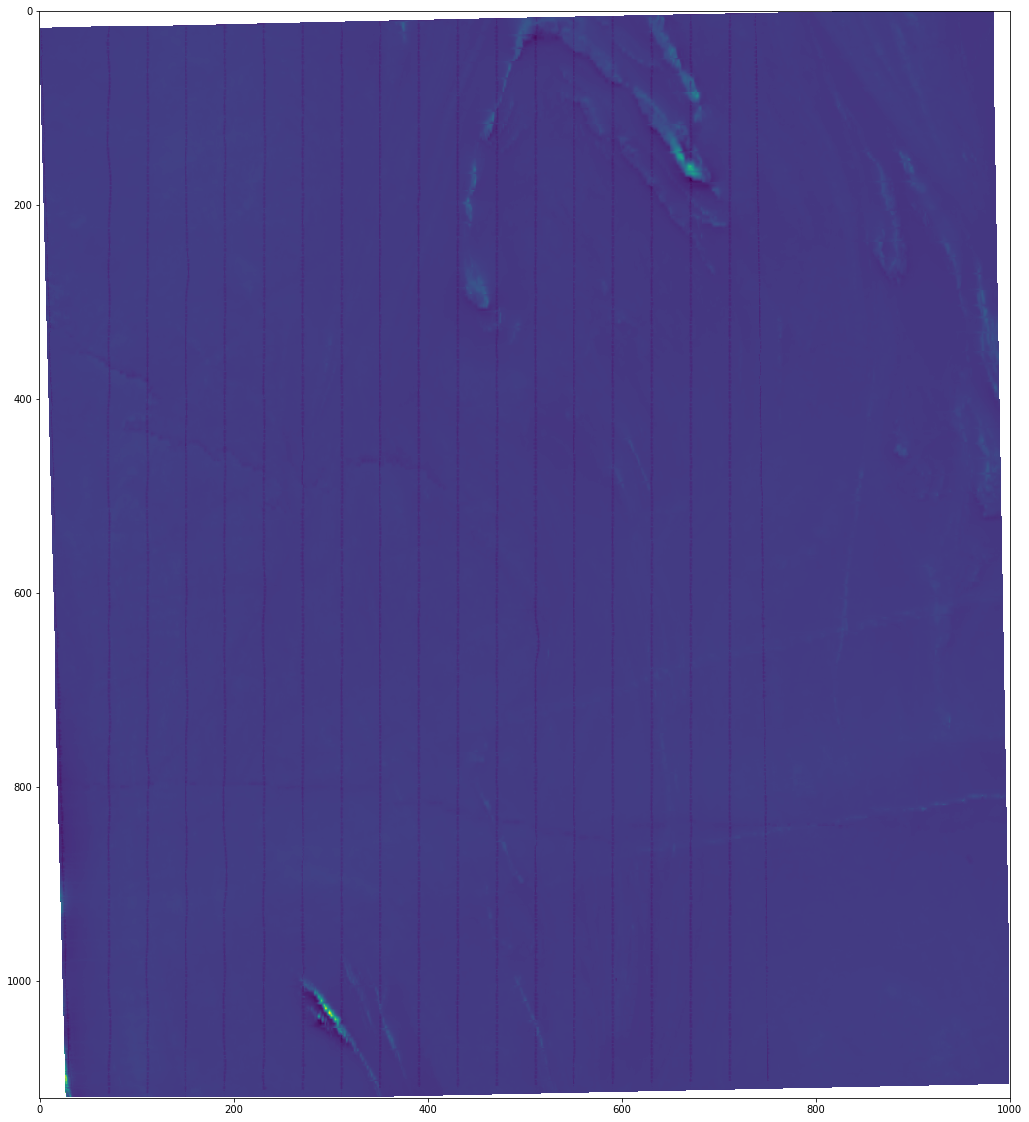

In [12]:
plt.figure(figsize=(30,20))    
plt.imshow(utm_mag_awags_grid)

In [13]:
gdal_dataset = array2file([utm_mag_awags_grid], wkt, geotransform, 'utm_mag_awags_grid.tif', 'GTiff')